In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn import CrossEntropyLoss, Linear, Softmax, Sigmoid, Module
import torch.optim as optim
from scipy.optimize import minimize
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.connectors import TorchConnector
import qiskit
import qiskit_machine_learning
print(qiskit.version.get_version_info())
print(qiskit_machine_learning.version.get_version_info())

1.2.4
0.8.0


In [12]:
# Creating Circuit

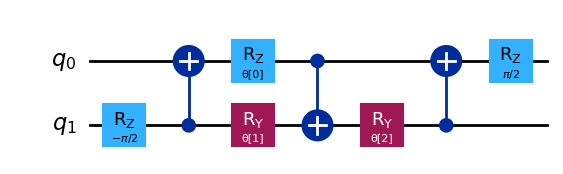

In [13]:
# Two qubit unitary as defined
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

# Visual
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl")

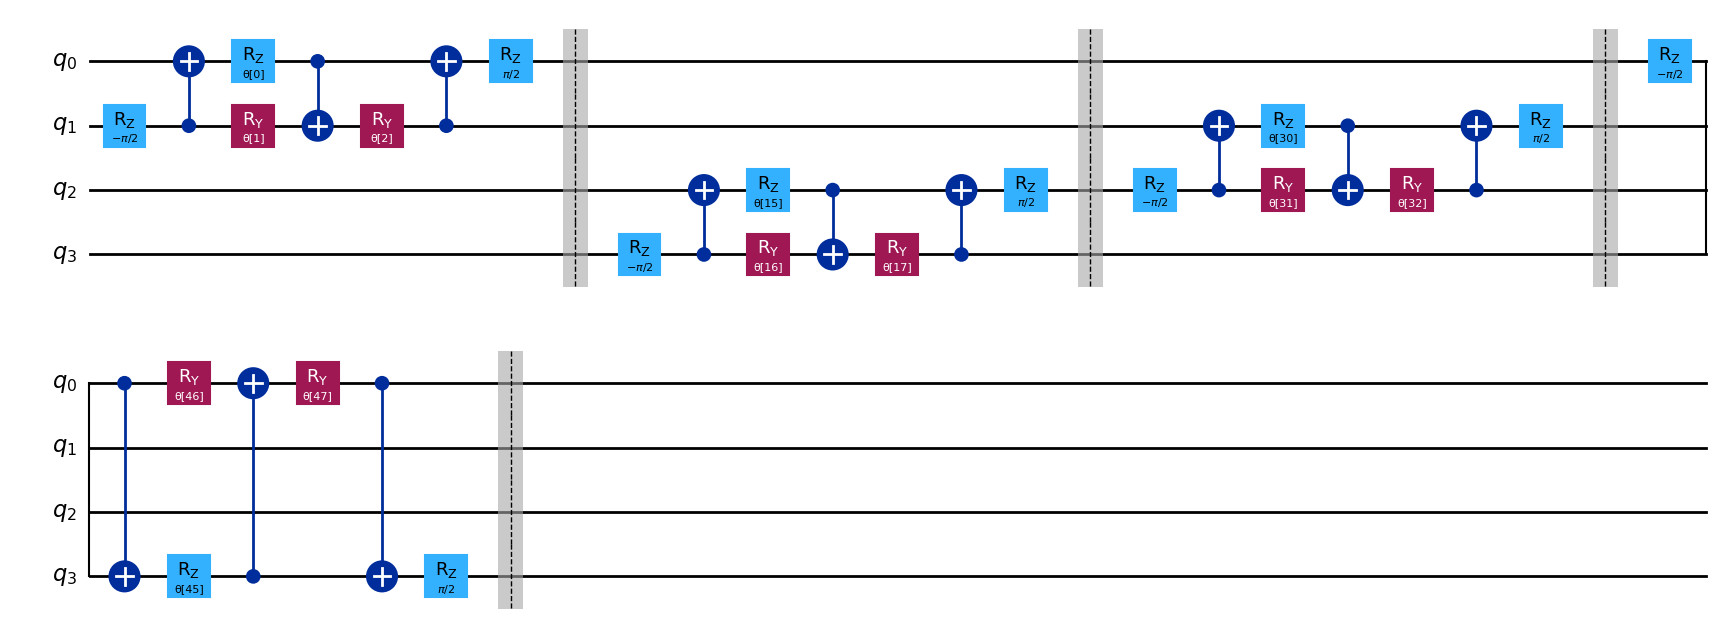

In [14]:
# Create Layer (Repeating Circuit on Neighboring Qubits).
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 15)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 15)]), [q1, q2])
        qc.barrier()
        param_index += 15
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 15)]), [q1, q2])
        qc.barrier()
        param_index += 15

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

# Visual
circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl")

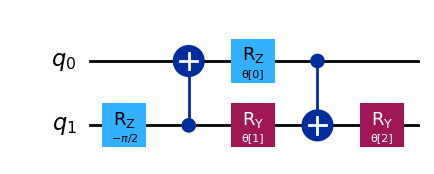

In [15]:
# Defining Pool Circuit
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target

# Visual
params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl")

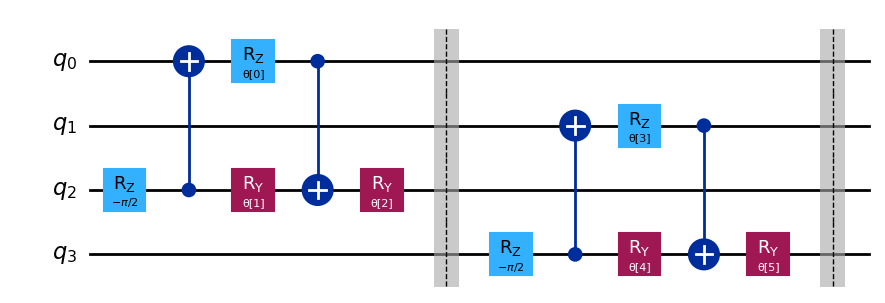

In [16]:
# Defining Pool Layer (Repeating Circuit on Neighboring Qubits)
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

# Visual
sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl")

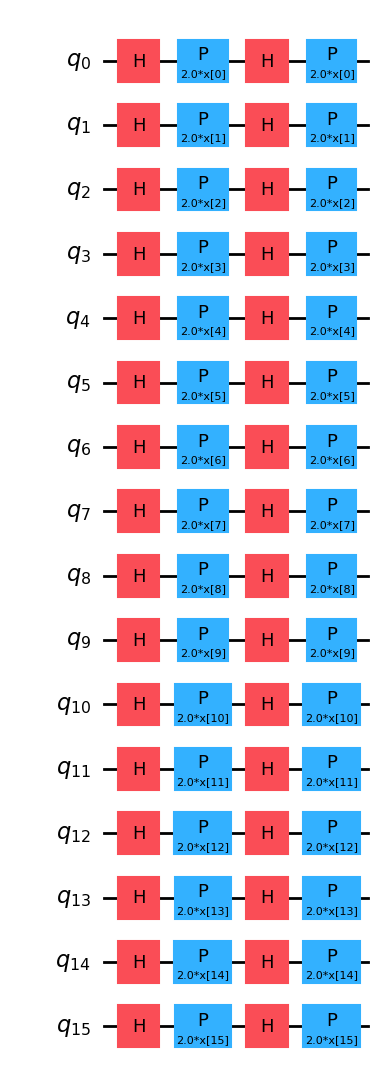

In [17]:
# Feature Map Instantiation
feature_map = ZFeatureMap(16)
feature_map.decompose().draw("mpl")

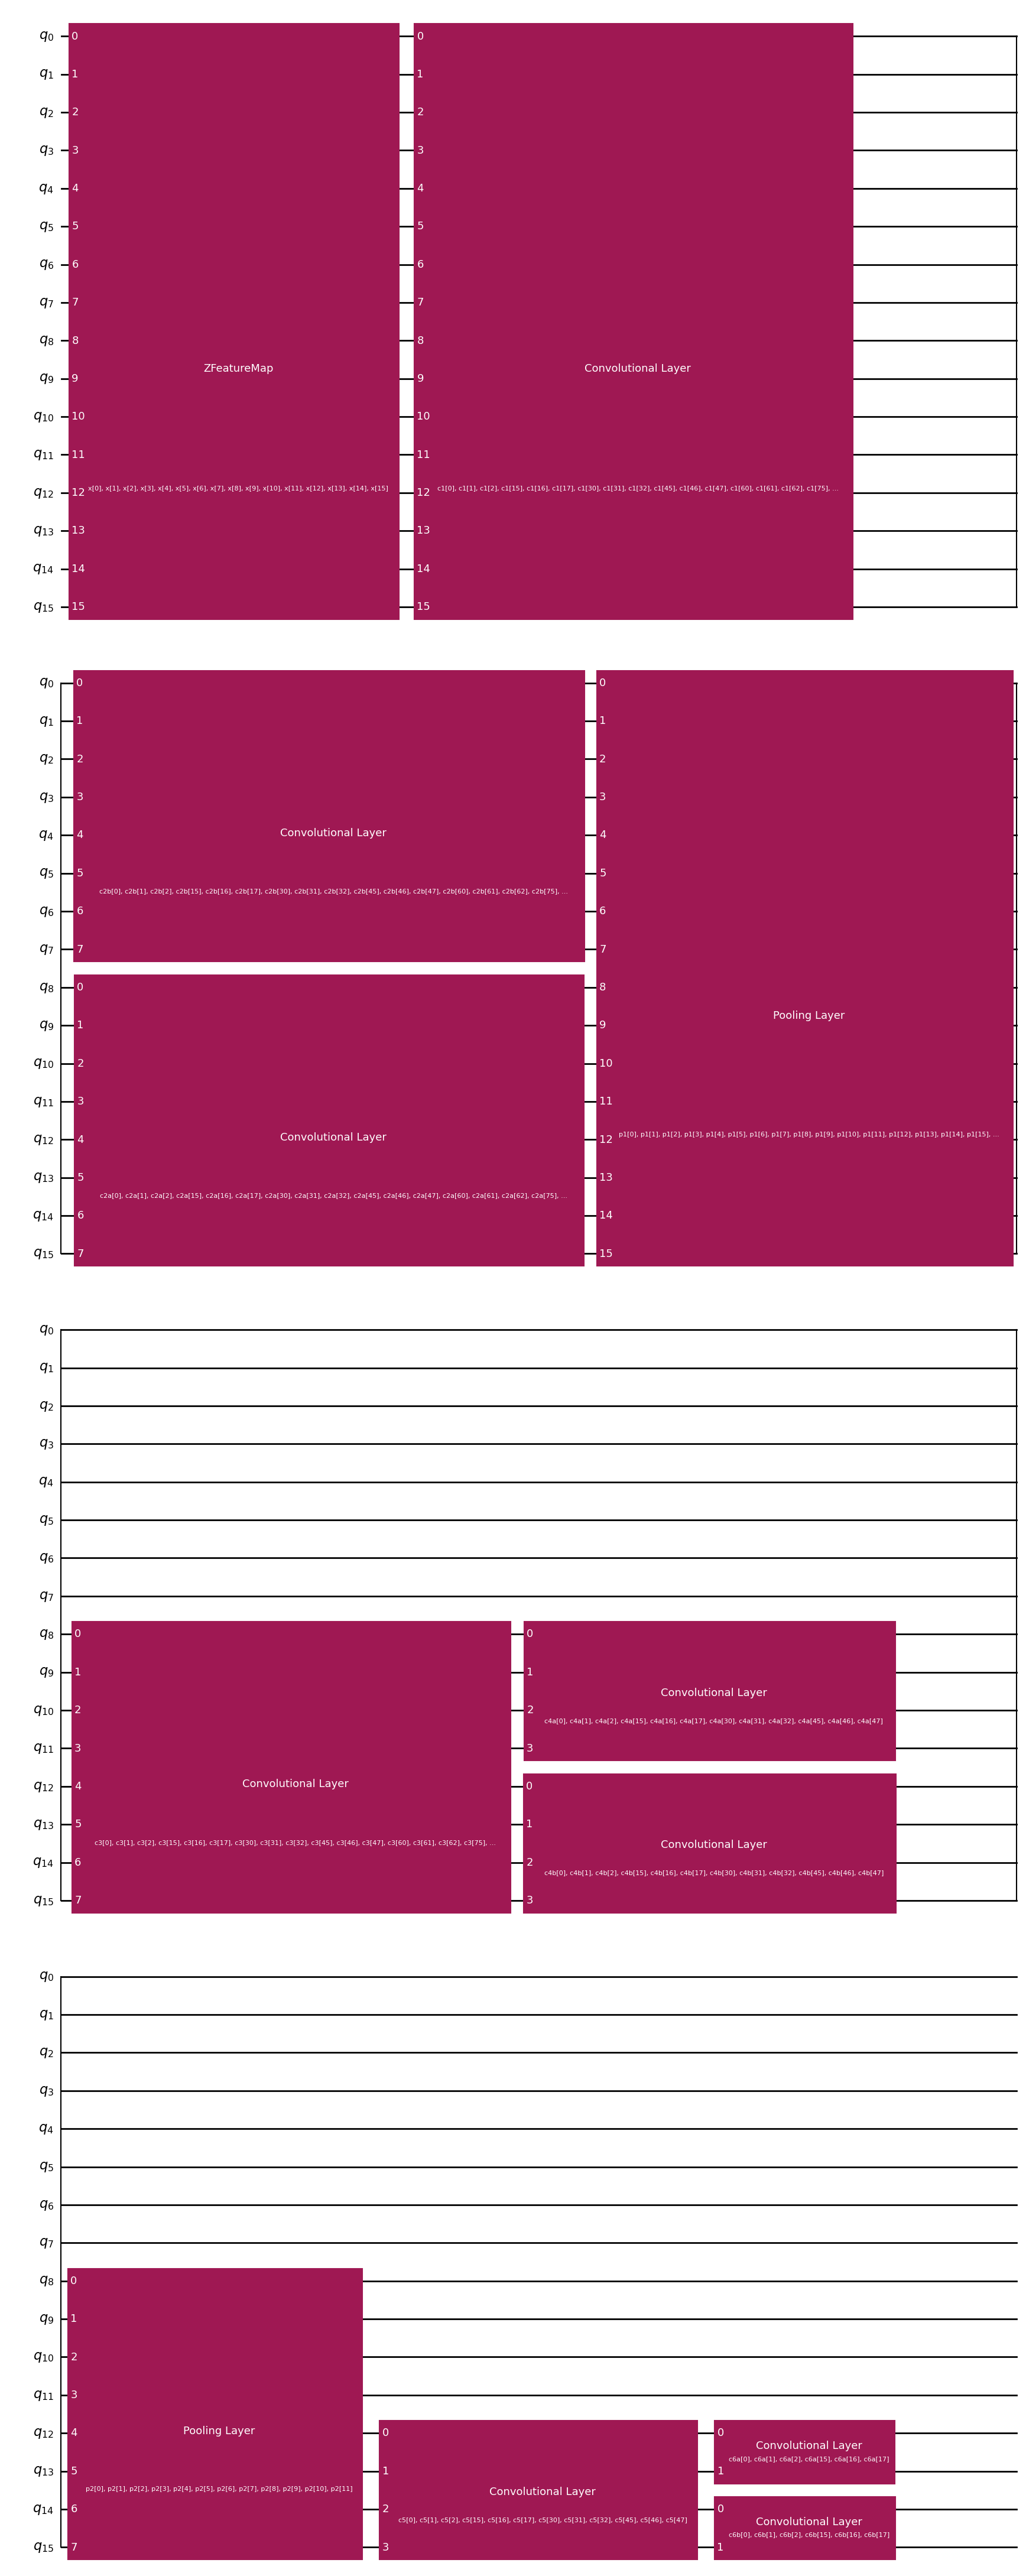

In [18]:
# Ansatz Instantiation Method
from qiskit import ClassicalRegister, QuantumRegister
def create_QCNN():
    q_reg = QuantumRegister(16, "q_reg")
    ansatz = QuantumCircuit(q_reg, name="Ansatz")

    # First Convolutional Layer
    ansatz.compose(conv_layer(16, "с1"), list(range(16)), inplace=True)

    # Second Convolutional Layer
    ansatz.compose(conv_layer(8, "c2a"), list(range(8, 16)), inplace=True)
    ansatz.compose(conv_layer(8, "c2b"), list(range(0, 8)), inplace=True)

    # First Pooling Layer
    ansatz.compose(pool_layer([0, 1, 2, 3, 4, 5, 6, 7], [8, 9, 10, 11, 12, 13, 14, 15], "p1"), list(range(16)), inplace=True)

    # Third Convolutional Layer
    ansatz.compose(conv_layer(8, "c3"), list(range(8, 16)), inplace=True)

    # Fourth Convolutional Layer
    ansatz.compose(conv_layer(4, "c4a"), list(range(8, 12)), inplace=True)
    ansatz.compose(conv_layer(4, "c4b"), list(range(12, 16)), inplace=True)

    # Second Pooling Layer
    ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p2"), list(range(8, 16)), inplace=True)

    # Fifth Convolutional Layer
    ansatz.compose(conv_layer(4, "c5"), list(range(12, 16)), inplace=True)

    # Sixth Convolutional Layer
    ansatz.compose(conv_layer(2, "c6a"), list(range(12, 14)), inplace=True)
    ansatz.compose(conv_layer(2, "c6b"), list(range(14, 16)), inplace=True)

    # Combining the feature map and ansatz
    circuit = QNNCircuit(16)
    circuit.feature_map = feature_map
    circuit.ansatz = ansatz
    return circuit

# Visual
display(create_QCNN().draw("mpl"))

In [19]:
# Creating/Formatting Data

In [20]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train[..., np.newaxis]/(255.0/np.pi), x_test[..., np.newaxis]/(255.0/np.pi)
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

2024-12-31 10:57:09.798865: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735671429.810600 1120022 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735671429.814082 1120022 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-31 10:57:09.825184: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Number of original training examples: 60000
Number of original test examples: 10000


In [21]:
# Filter Values
a = 3
b = 4
c = 5
d = 6
def filter_abcd(x, y):
    keep = (y == a) | (y == b) | (y == c) | (y == d)
    x, y = x[keep], y[keep]
    return x,y

In [22]:
# Filtering using previous method.
x_train, y_train = filter_abcd(x_train, y_train)
x_test, y_test = filter_abcd(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 23312
Number of filtered test examples: 3842


6


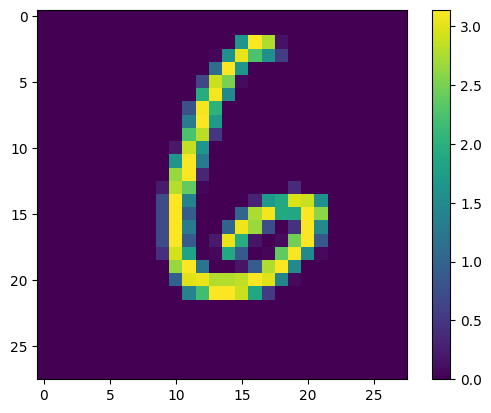

In [23]:
# Displaying Sample Image
img = 13
print(y_train[img])
plt.imshow(x_train[img, :, :, 0])
plt.colorbar()

In [24]:
# Resizing (Quantum Computing Simulation Limit)
x_train_small = tf.image.resize(x_train, (4,4), method = 'area').numpy()
x_test_small = tf.image.resize(x_test, (4,4), method = 'area').numpy()

I0000 00:00:1735671432.782195 1120022 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21458 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


6


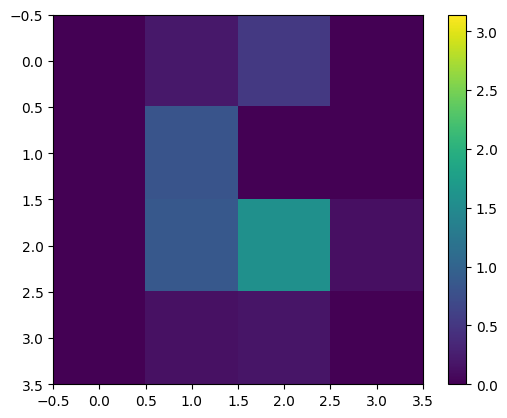

In [25]:
# Displaying Image Sample After Resizing
img = 13
print(y_train[img])
plt.imshow(x_train_small[img,:,:,0], vmin=0, vmax=np.pi)
plt.colorbar()

In [26]:
# Formatting Helper Methods
def format_data(a,b):
    x_reshaped = []
    x1_reshaped = []

    for g in a:
        x_reshaped.append(g.reshape(1,16))

    for g in b:
        x1_reshaped.append(g.reshape(1,16))

    final_x = []
    final_x1 = []

    for entry in x_reshaped:
        final_x.append(entry[0])

    for entry in x1_reshaped:
        final_x1.append(entry[0])
    return final_x, final_x1

def format_labels(y):
    y_temp = []
    for entry in y:
        if entry == a:
            y_temp.append(0)
        elif entry == b:
            y_temp.append(1)
        elif entry == c:
            y_temp.append(2)
        elif entry == d:
            y_temp.append(3)
    return y_temp

In [27]:
x,x1 = format_data(x_train_small, x_test_small)

# Easier to work with names
y = y_train
y1 = y_test

# Setting labels to 0,1,2,3 for easy reference later
y = format_labels(y)
y1 = format_labels(y1)

# Converting to nparray
x = np.asarray(x)
y = np.asarray(y)
x1 = np.asarray(x1)
y1 = np.asarray(y1)

# Limiting training dataset to lower training time.
x = x[0:256]
y = y[0:256]
x1 = x1[0:256]
y1 = y1[0:256]
print(x)
print(y)

[[0.         0.19058241 0.5850729  ... 1.2083628  0.15663964 0.        ]
 [0.0359542  0.         0.04701703 ... 0.         0.54685587 0.        ]
 [0.         0.26902792 0.86968946 ... 1.3765682  0.4684103  0.        ]
 ...
 [0.         0.3354049  0.         ... 0.40329048 0.46539322 0.        ]
 [0.         0.0548113  0.8850265  ... 0.9554263  0.27833077 0.        ]
 [0.         0.10283405 0.05279988 ... 0.35426205 0.24916515 0.        ]]
[2 1 0 1 0 2 0 3 3 1 1 0 0 3 2 3 3 0 2 0 0 1 1 1 1 3 1 2 3 3 0 3 0 1 3 1 3
 0 2 3 0 0 1 3 1 3 0 1 2 0 0 2 1 1 2 3 0 1 3 3 0 1 1 3 1 2 2 0 0 2 3 2 1 0
 0 3 0 0 1 3 2 3 1 0 0 2 1 3 2 3 0 2 0 0 0 3 1 2 3 2 1 1 2 3 1 2 0 0 2 3 2
 1 0 1 1 1 0 3 3 2 3 1 2 0 3 0 2 1 0 3 2 2 1 1 0 1 1 0 0 1 3 1 1 1 2 1 1 3
 0 3 2 3 1 2 0 2 1 1 1 2 2 3 0 3 3 0 2 1 1 3 0 0 1 2 3 2 0 2 1 0 3 0 3 0 2
 3 0 2 2 3 0 2 2 2 2 2 1 3 3 2 0 1 2 2 0 3 0 2 0 0 1 3 1 0 1 3 2 0 1 1 3 3
 3 1 1 3 2 0 2 1 2 2 3 2 0 3 2 0 0 1 3 2 2 1 3 0 3 1 1 3 0 3 0 1 2 1]


In [28]:
# Additional Helper Functions
def count(y):
    counta = 0
    countb = 0
    countc = 0
    countd = 0
    for i in range(len(y)):
        if y[i] == 0:
            counta+=1
        elif y[i] == 1:
            countb+=1
        elif y[i] == 2:
            countc+=1
        elif y[i] == 3:
            countd+=1
    return(counta, countb, countc, countd)

def balance_lists(x, y, max_count):
    """Balances two lists x and y based on the values in y (0 or 1)."""
    
    x_balanced = []
    y_balanced = []
    count0 = 0
    count1 = 0
    count2 = 0
    count3 = 0

    for i in range(len(y)):
        if y[i] == 0:
            if count0 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count0 += 1
        elif y[i] == 1:
            if count1 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count1 += 1
        elif y[i] == 2:
            if count2 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count2 += 1
        elif y[i] == 3:
            if count3 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count3 += 1
    return x_balanced, y_balanced

def shuffle(arr1, arr2):
    assert len(arr1) == len(arr2)
    p = np.random.permutation(len(arr1))
    return arr1[p], arr2[p]

In [29]:
# Further Data Cleaning Using Helper Functions
nums = count(y)
print("original:", nums)
max_count = min(nums)
print("max_count =", max_count)
x,y = balance_lists(x, y, max_count)

print("balanced:", count(y))

# Converting to nparray
x = np.asarray(x)
y = np.asarray(y)
x1 = np.asarray(x1)
y1 = np.asarray(y1)
objective_func_vals = []

x,y = shuffle(x,y)
print("shuffled:", count(y))

print("final:", x)
print(y)

original: (66, 68, 60, 62)
max_count = 60
balanced: (60, 60, 60, 60)
shuffled: (60, 60, 60, 60)
final: [[0.         0.8872893  0.3678391  ... 1.1781915  0.62580425 0.        ]
 [0.         0.20491381 1.0218033  ... 0.98283195 0.4734389  0.        ]
 [0.13702825 0.         0.3386735  ... 0.         0.4075648  0.18102817]
 ...
 [0.0359542  0.         0.04701703 ... 0.         0.54685587 0.        ]
 [0.         0.         0.0125714  ... 0.6554727  0.02137138 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[0 0 1 2 2 0 2 0 1 2 2 3 0 2 2 3 1 3 2 0 2 0 2 0 1 1 0 1 1 2 2 2 3 3 0 2 1
 3 0 0 0 3 3 2 2 2 2 2 1 0 3 1 2 3 0 0 3 0 0 3 0 0 3 1 1 1 3 1 1 1 1 3 2 3
 3 2 1 2 0 0 0 3 1 0 1 0 1 0 0 3 1 1 0 1 2 3 2 0 0 3 2 1 0 1 2 1 2 2 1 1 0
 3 2 1 3 1 1 1 2 0 3 3 0 0 0 3 3 3 2 3 2 0 1 0 0 3 2 3 0 0 0 1 2 2 1 2 2 2
 2 1 0 3 2 3 0 0 2 1 1 0 1 0 2 0 3 1 3 0 3 1 0 0 0 0 2 1 1 2 2 1 3 3 3 0 1
 3 0 2 0 2 3 2 3 3 3 3 3 1 2 3 3 1 1 3 1 3 2 2 0 1 2 1 1 2 1 0 2 3 0 1 3 3
 1 

In [30]:
# Tensor for Pytorch
X = torch.tensor(x, dtype=torch.float32).to("cuda")
Y = torch.tensor(y, dtype=torch.long).to("cuda")
X1 = torch.tensor(x1, dtype=torch.float32).to("cuda")
Y1 = torch.tensor(y1, dtype=torch.long).to("cuda")

In [31]:
# One-Hot Encoding for Final Processing
num_classes = 4
Y = (torch.nn.functional.one_hot(Y, num_classes=num_classes).float())
Y1 = (torch.nn.functional.one_hot(Y1, num_classes=num_classes).float())

In [32]:
print(X,Y,X1,Y1)

tensor([[0.0000, 0.8873, 0.3678,  ..., 1.1782, 0.6258, 0.0000],
        [0.0000, 0.2049, 1.0218,  ..., 0.9828, 0.4734, 0.0000],
        [0.1370, 0.0000, 0.3387,  ..., 0.0000, 0.4076, 0.1810],
        ...,
        [0.0360, 0.0000, 0.0470,  ..., 0.0000, 0.5469, 0.0000],
        [0.0000, 0.0000, 0.0126,  ..., 0.6555, 0.0214, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0') tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
      

In [33]:
# Training

In [34]:
# Pytorch Circuit Module
import torch.nn as nn
class Model(Module): # Simplified
    def __init__(self, qnn_module):
        super().__init__()
        self.qnn_module = qnn_module

    def forward(self, x):
        x = self.qnn_module(x)
        return x

In [35]:
from qiskit_aer.primitives import Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_algorithms.gradients import ReverseEstimatorGradient
from qiskit_machine_learning.utils import algorithm_globals

# Reproducable seeds
num_qubits = 16
algorithm_globals.random_seed = 65
seed = 90

# Creating GPU compatible Estimator primitive
sampler = Estimator()
sampler.set_options(device='GPU')
sampler.set_options(method="statevector")
sampler.set_options(seed = seed)

# Setting observables on 15th and 16th qubits.
observable_z16 = SparsePauliOp.from_sparse_list([("Z", [15], 1)], num_qubits=num_qubits)
observable_z15 = SparsePauliOp.from_sparse_list([("Z", [14], 1)], num_qubits=num_qubits)
observable_z14 = SparsePauliOp.from_sparse_list([("Z", [13], 1)], num_qubits=num_qubits)
observable_z13 = SparsePauliOp.from_sparse_list([("Z", [12], 1)], num_qubits=num_qubits)
observables = [observable_z13, observable_z14, observable_z15, observable_z16]

# Instantiating underlying EstimatorQNN
estimator = EstimatorQNN(
    estimator = sampler,
    circuit = create_QCNN(),
    observables = observables,
    gradient = ReverseEstimatorGradient(sampler),
    input_gradients = True,
)

# Initial Forward Weights
weights = algorithm_globals.random.random(estimator.num_weights)

# Checking Data Forward Result
estimator.forward(input_data = x1[:30], weights = weights)

/tmp/ipykernel_1120022/1038025662.py:25: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  estimator = EstimatorQNN(
/tmp/ipykernel_1120022/1038025662.py:25: UserWarning: No number of qubits was not specified (None) and was retrieved from `circuit` (16). If `circuit` is transpiled, this may cause unstable behaviour.
  estimator = EstimatorQNN(


array([[ 0.04296875, -0.02148438, -0.0546875 , -0.015625  ],
       [ 0.0234375 ,  0.06835938, -0.046875  ,  0.05664062],
       [-0.00195312,  0.03710938,  0.046875  ,  0.05859375],
       [-0.02148438,  0.00195312,  0.01757812,  0.0078125 ],
       [ 0.04101562,  0.03710938, -0.04296875, -0.00976562],
       [-0.02148438,  0.02148438,  0.04296875,  0.03125   ],
       [-0.02929688, -0.00585938,  0.00390625, -0.00976562],
       [-0.00195312,  0.00585938, -0.015625  , -0.0078125 ],
       [-0.00390625,  0.01171875,  0.046875  , -0.0078125 ],
       [ 0.05273438,  0.02929688, -0.01171875, -0.05664062],
       [ 0.        ,  0.07617188,  0.04296875, -0.04492188],
       [ 0.02929688,  0.03515625, -0.01757812,  0.06835938],
       [-0.0078125 ,  0.03125   ,  0.04296875, -0.0234375 ],
       [ 0.        ,  0.02929688, -0.02148438,  0.04296875],
       [-0.046875  ,  0.01757812, -0.02929688,  0.02539062],
       [ 0.0078125 ,  0.01757812,  0.00195312,  0.00195312],
       [ 0.04296875, -0.

In [36]:
# Wrapping estimator with initial weights under TorchConnecter, itself under Pytorch Module.
model = Model(TorchConnector(estimator, weights))
model.to("cuda")
next(model.parameters()).is_cuda

True

In [37]:
def accuracy(output, y):
    preds = torch.argmax(output, dim=1)
    true = torch.argmax(y, dim=1)
    correct = (preds == true).sum().item()
    return (correct / y.size(0)) * 100

In [38]:
def train(model, X, Y, loss_function, optimizer, epochs, loss_list = [], acc_list = [], test_acc_list=[], i = 0):
    optimizer = optim.Adam(model.parameters(), lr=0.1)
    if i == 0:
        output = model(X)
        output0 = model(X1)
        epoch_loss = loss_function(output, Y).item()
        epoch_acc = accuracy(output, Y)
        epoch_test_acc = accuracy(output0, Y1)
        loss_list.append(epoch_loss)
        acc_list.append(epoch_acc)
        test_acc_list.append(epoch_test_acc)
        print(f"Epoch: {i}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, Test Accuracy: {epoch_test_acc:.2f}%")
    else:
        for e in range(i+1): # Considering 0th epoch in list as well
            print(f"Epoch: {e}, Loss: {loss_list[e]:.4f}, Accuracy: {acc_list[e]:.2f}%, Test Accuracy: {test_acc_list[e]:.2f}%")   
        
    for epoch in range(epochs):
        # Forward pass
        output = model(X)
        loss = loss_function(output, Y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate loss and accuracy for the entire epoch (optional, for monitoring)
        with torch.no_grad():
            output = model(X)
            output0 = model(X1)
            epoch_loss = loss_function(output, Y).item()
            epoch_acc = accuracy(output, Y)
            epoch_test_acc = accuracy(output0, Y1)
            loss_list.append(epoch_loss)
            acc_list.append(epoch_acc)
            test_acc_list.append(epoch_test_acc)
            print(f"Epoch: {epoch+1+i}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, Test Accuracy: {epoch_test_acc:.2f}%")
    return loss_list, acc_list, test_acc_list

In [39]:
# # Loading Epoch Checkpoint
# model = torch.load("4Qubits(One_Hot)EnhancedCirc_ADAM_256_95Epoch.pth", weights_only=False).to("cuda")['model']
# optimizer = torch.load("4Qubits(One_Hot)EnhancedCirc_ADAM_256_95Epoch.pth", weights_only=False).to("cuda")['optimizer']

optimizer = optimizer = optim.Adam(model.parameters(), lr=0.1)
loss_function = CrossEntropyLoss()

In [48]:
# Train the Model
loss_list, acc_list, test_acc_list = train(model = model, X = X, Y = Y, optimizer = optimizer, loss_function = loss_function, i = 10, epochs = 30, loss_list=loss_list, acc_list=acc_list, test_acc_list=test_acc_list)

Epoch: 0, Loss: 1.3898, Accuracy: 22.08%, Test Accuracy: 23.05%
Epoch: 1, Loss: 1.3788, Accuracy: 30.83%, Test Accuracy: 30.86%
Epoch: 2, Loss: 1.3694, Accuracy: 33.33%, Test Accuracy: 32.03%
Epoch: 3, Loss: 1.3520, Accuracy: 35.42%, Test Accuracy: 30.08%
Epoch: 4, Loss: 1.3279, Accuracy: 47.50%, Test Accuracy: 38.67%
Epoch: 5, Loss: 1.3067, Accuracy: 55.00%, Test Accuracy: 42.97%
Epoch: 6, Loss: 1.2834, Accuracy: 54.58%, Test Accuracy: 44.92%
Epoch: 7, Loss: 1.2655, Accuracy: 50.42%, Test Accuracy: 42.97%
Epoch: 8, Loss: 1.2516, Accuracy: 50.00%, Test Accuracy: 42.97%
Epoch: 9, Loss: 1.2372, Accuracy: 55.83%, Test Accuracy: 50.00%
Epoch: 10, Loss: 1.2228, Accuracy: 60.83%, Test Accuracy: 56.64%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 11, Loss: 1.2306, Accuracy: 50.42%, Test Accuracy: 45.70%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 12, Loss: 1.1862, Accuracy: 57.92%, Test Accuracy: 50.39%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 13, Loss: 1.1752, Accuracy: 70.00%, Test Accuracy: 55.86%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 14, Loss: 1.1644, Accuracy: 71.25%, Test Accuracy: 58.59%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 15, Loss: 1.1429, Accuracy: 71.25%, Test Accuracy: 58.59%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 16, Loss: 1.1277, Accuracy: 67.92%, Test Accuracy: 54.69%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 17, Loss: 1.1239, Accuracy: 70.00%, Test Accuracy: 55.08%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 18, Loss: 1.1162, Accuracy: 72.08%, Test Accuracy: 60.16%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 19, Loss: 1.1037, Accuracy: 71.25%, Test Accuracy: 64.84%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 20, Loss: 1.0945, Accuracy: 70.42%, Test Accuracy: 66.41%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 21, Loss: 1.0891, Accuracy: 71.25%, Test Accuracy: 68.36%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 22, Loss: 1.0860, Accuracy: 72.50%, Test Accuracy: 69.14%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 23, Loss: 1.0810, Accuracy: 70.83%, Test Accuracy: 68.36%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 24, Loss: 1.0757, Accuracy: 71.25%, Test Accuracy: 68.36%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 25, Loss: 1.0718, Accuracy: 70.00%, Test Accuracy: 67.19%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 26, Loss: 1.0664, Accuracy: 72.50%, Test Accuracy: 66.02%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 27, Loss: 1.0603, Accuracy: 71.67%, Test Accuracy: 66.02%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 28, Loss: 1.0571, Accuracy: 71.25%, Test Accuracy: 65.23%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 29, Loss: 1.0538, Accuracy: 70.42%, Test Accuracy: 64.45%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 30, Loss: 1.0491, Accuracy: 70.83%, Test Accuracy: 64.84%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 31, Loss: 1.0445, Accuracy: 71.67%, Test Accuracy: 64.84%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 32, Loss: 1.0394, Accuracy: 72.08%, Test Accuracy: 64.06%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 33, Loss: 1.0334, Accuracy: 72.08%, Test Accuracy: 63.67%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 34, Loss: 1.0291, Accuracy: 71.67%, Test Accuracy: 65.23%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 35, Loss: 1.0243, Accuracy: 70.42%, Test Accuracy: 64.06%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 36, Loss: 1.0212, Accuracy: 70.83%, Test Accuracy: 63.28%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 37, Loss: 1.0193, Accuracy: 69.58%, Test Accuracy: 62.11%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 38, Loss: 1.0176, Accuracy: 68.75%, Test Accuracy: 61.72%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 39, Loss: 1.0164, Accuracy: 69.58%, Test Accuracy: 60.16%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 40, Loss: 1.0154, Accuracy: 69.17%, Test Accuracy: 58.98%


In [49]:
print(loss_list, acc_list, test_acc_list)

[1.3897807598114014, 1.378823161125183, 1.369391918182373, 1.3520176410675049, 1.3278847932815552, 1.3066529035568237, 1.2834432125091553, 1.2655011415481567, 1.2515500783920288, 1.237183690071106, 1.2228305339813232, 1.2306089401245117, 1.1861704587936401, 1.1751679182052612, 1.1643612384796143, 1.1428688764572144, 1.12765634059906, 1.123877763748169, 1.1162351369857788, 1.1037073135375977, 1.0945371389389038, 1.0891309976577759, 1.0860204696655273, 1.080973505973816, 1.0756797790527344, 1.071846604347229, 1.0663594007492065, 1.060313105583191, 1.0571036338806152, 1.0537796020507812, 1.0491464138031006, 1.0445131063461304, 1.0393515825271606, 1.0334233045578003, 1.029083251953125, 1.0242912769317627, 1.0212386846542358, 1.019323706626892, 1.0176167488098145, 1.0163581371307373, 1.0154495239257812] [22.083333333333332, 30.833333333333336, 33.33333333333333, 35.41666666666667, 47.5, 55.00000000000001, 54.58333333333333, 50.416666666666664, 50.0, 55.833333333333336, 60.83333333333333, 50

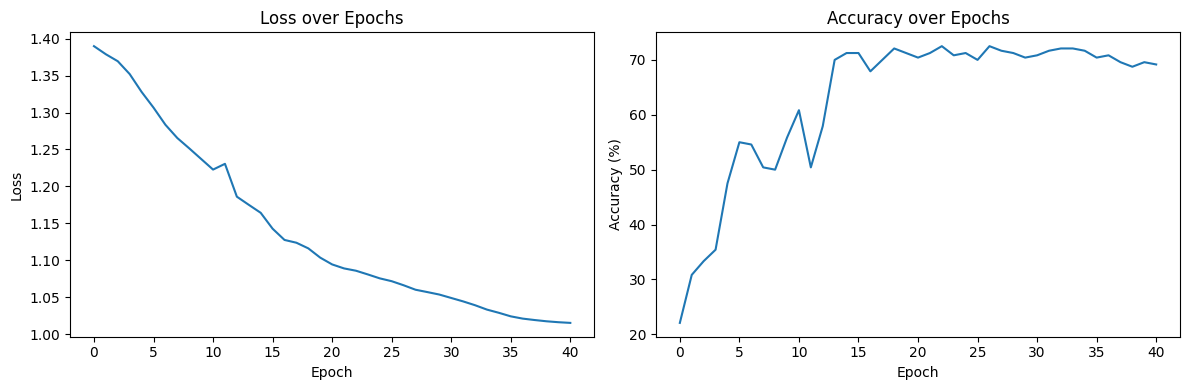

In [50]:
# Plot Loss and Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_list)
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(acc_list)
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")

plt.tight_layout()
plt.show()

In [51]:
savemodel = {'model': model, 'optimizer': optimizer.state_dict()}
print(next(model.parameters()).is_cuda)
torch.save(savemodel, "Circuit8")
print(next(model.parameters()).is_cuda)

True
True


In [52]:
evalmodel = torch.load("Circuit8", weights_only=False)['model'].to("cuda")
evalmodel.eval()
output0 = evalmodel(X)
output1 = evalmodel(X1)
print(f"Train Accuracy: {accuracy(output0, Y)}%")
print(f"Test Accuracy: {accuracy(output1, Y1)}%")

Train Accuracy: 69.16666666666667%
Test Accuracy: 58.984375%


In [53]:
def translate(array):
    arr = []
    for e in array:
        arr.append(torch.argmax(e))
    return arr
print(f"output 0: {translate(output0)}, \n Y:       {translate(Y)}, \n output 1: {translate(output1)}, \n Y1:       {translate(Y1)}")

output 0: [tensor(0, device='cuda:0'), tensor(2, device='cuda:0'), tensor(1, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(0, device='cuda:0'), tensor(2, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(2, device='cuda:0'), tensor(1, device='cuda:0'), tensor(3, device='cuda:0'), tensor(2, device='cuda:0'), tensor(3, device='cuda:0'), tensor(3, device='cuda:0'), tensor(3, device='cuda:0'), tensor(1, device='cuda:0'), tensor(3, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(3, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(2, device='cuda:0'), tensor(1, device='cuda:0'), tensor(2, device='cuda:0'), tensor(3, device='cuda:0'), tensor(1, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2,

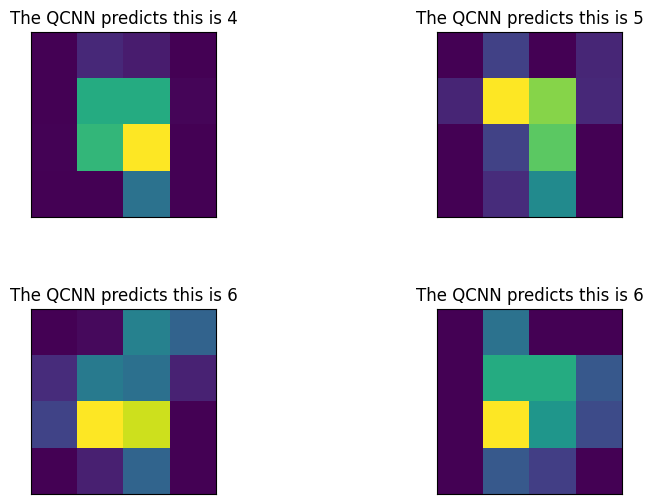

In [54]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(X1.detach().cpu().numpy()[i].reshape(4, 4), aspect="equal")
    if torch.argmax(output1[i]) == 0:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is 3")
    if torch.argmax(output1[i]) == 1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is 4")
    if torch.argmax(output1[i]) == 2:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is 5")
    if torch.argmax(output1[i]) == 3:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is 6")
plt.subplots_adjust(wspace=0.1, hspace=0.5)

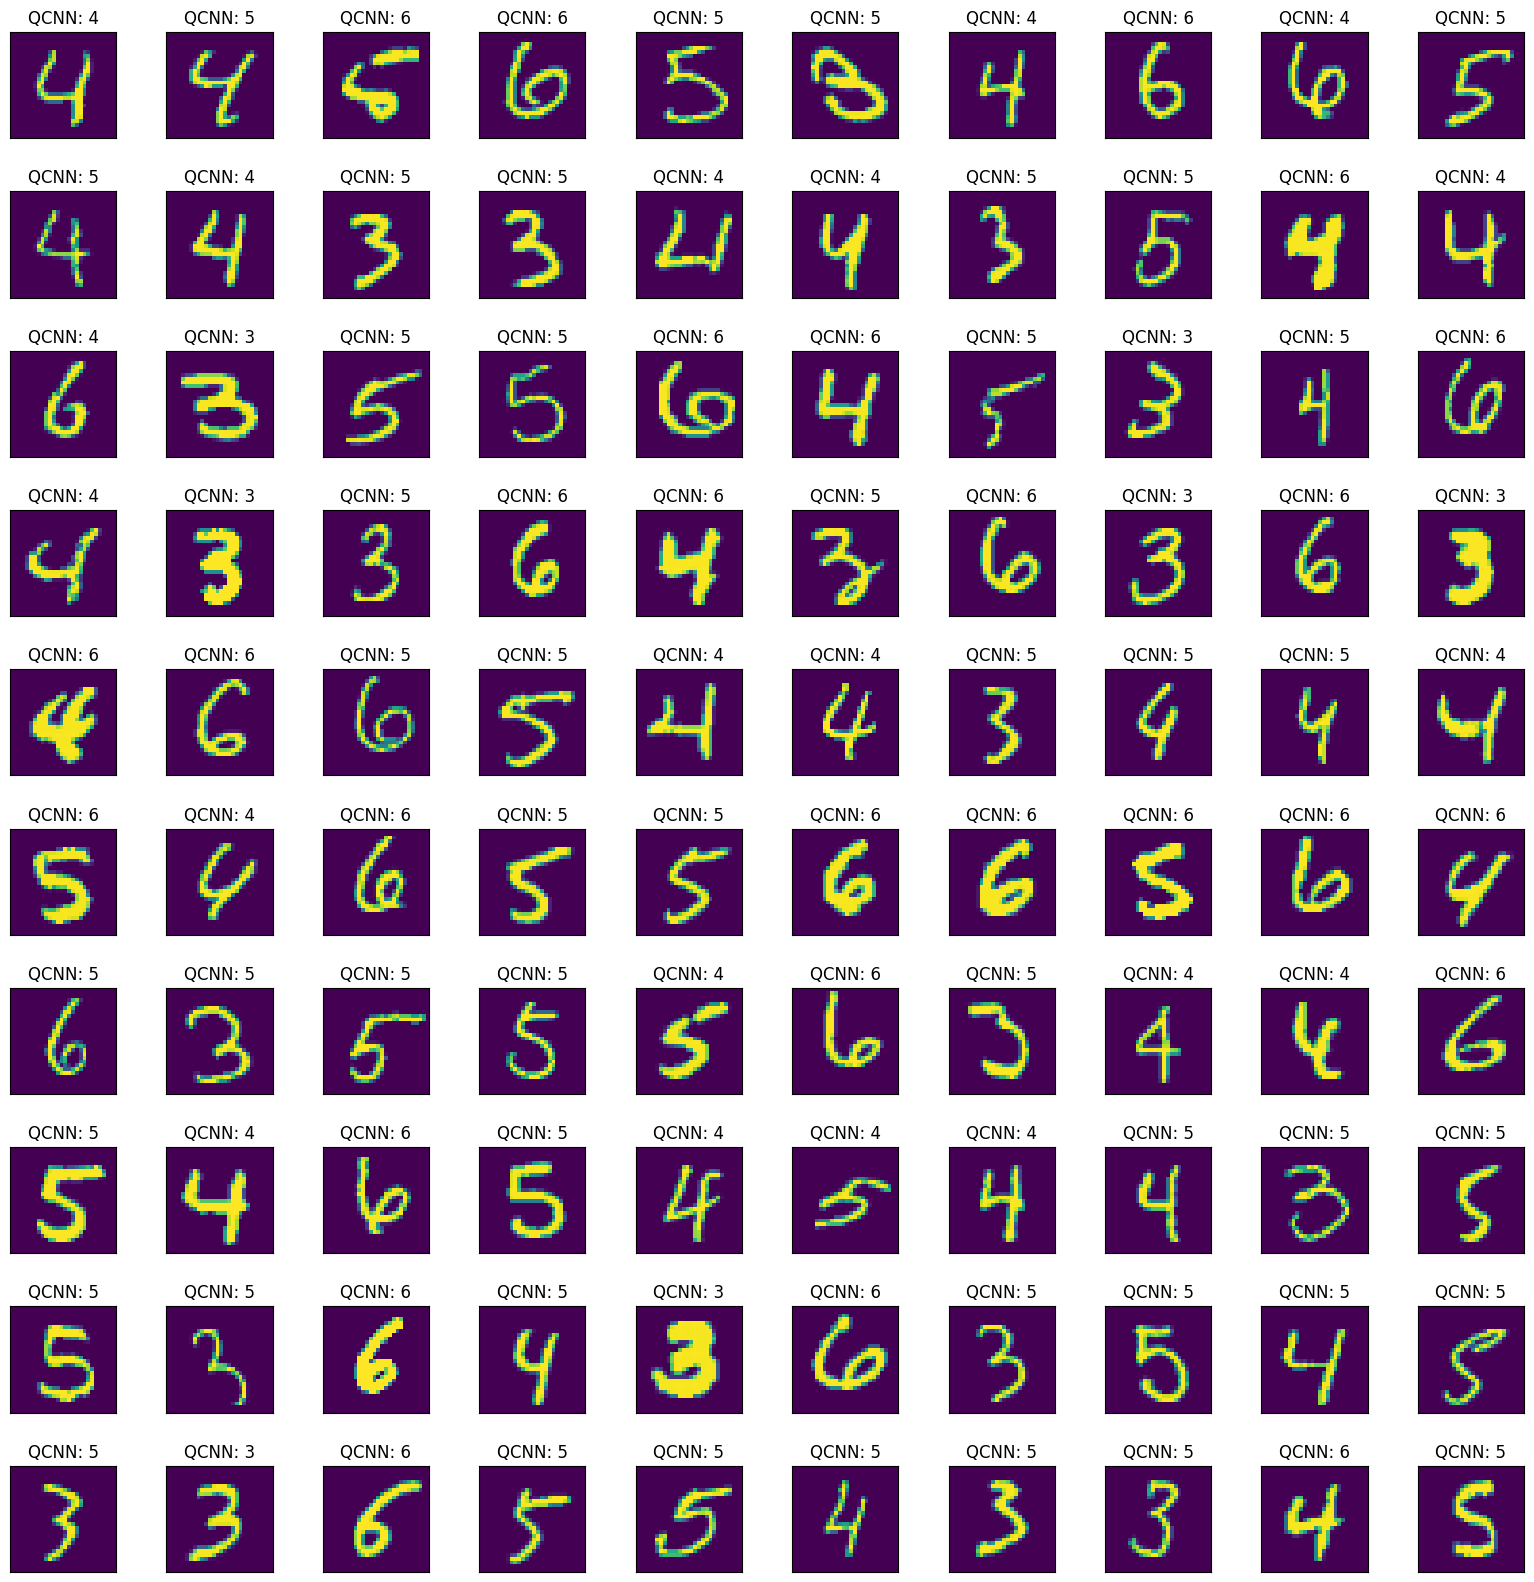

In [55]:
num_rows = 10
num_cols = 10
fig, ax = plt.subplots(num_rows, num_cols, figsize=(20, 20),
                       subplot_kw={"xticks": [], "yticks": []})

for i in range(num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    
    if i < len(x_test) and i < len(output1):
      ax[row, col].imshow(x_test[i].reshape(28, 28), aspect="equal")

      if torch.argmax(output1[i]) == 0:
          ax[row, col].set_title("QCNN: 3")
      elif torch.argmax(output1[i]) == 1:
          ax[row, col].set_title("QCNN: 4")
      elif torch.argmax(output1[i]) == 2:
          ax[row, col].set_title("QCNN: 5")
      elif torch.argmax(output1[i]) == 3:
          ax[row, col].set_title("QCNN: 6")
    else:
        ax[row, col].axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.5)
plt.show()